In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import cv2 as cv
import imutils
import glob
import csv
import os
from pathlib import Path
from google.colab.patches import cv2_imshow
# from google.colab import drive
# drive.mount('/content/drive')

In [77]:
Test_img = 'IMG_029'

In [78]:
Test_Folder = '/content/'
rLocate = r'/content/'
rTest = r'/content/'
dataset_path = '/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/Train_new.csv'
eval_path = '/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/Eval_taiwan.csv'
test_path = '/content/output_obj.csv'
Image_path = '/content//' + Test_img + '.jpg'
model_path = '/content/__EquationSolver_Model__Finalversion_MLP'
Resize_Height = 300

In [79]:
class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

class Normalization:
    def __call__(self, sample):
        inputs, targets = sample
        inputs /= 255.0
        return inputs, targets

transform = transforms.Compose(
    [ToTensor(),
     Normalization()
     ])

class MnistDataset(Dataset):

    def __init__(self, path, transform):
        self.transform = transform
        train_data = np.loadtxt(path, delimiter=",",
                                dtype=np.float, skiprows=1)
        self.train_x = train_data[:, 1:]
        self.train_y = train_data[:, [0]]
        self.n_samples = train_data.shape[0]

    def __getitem__(self, index):
        sample = self.train_x[index], self.train_y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.n_samples


class TestData(Dataset):

    def __init__(self, path, transform):
        self.transform = transform
        train_data = np.loadtxt(path, delimiter=",",
                                dtype=np.float, skiprows=1)
        self.train_x = train_data[:, :]
        self.dummy = train_data[:, [0]]
        self.n_samples = train_data.shape[0]

    def __getitem__(self, index):
        sample = self.train_x[index], self.dummy[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.n_samples

In [80]:
def Transfor2square(image):
    padding = 40
    x, y = image.shape[:2]
    # print(x, y)
    shape = max(x, y)
    new_im = np.zeros((shape+padding, shape+padding, 3), np.uint8)
    ax, ay = (shape - image.shape[1] +
              padding)//2, (shape - image.shape[0]+padding)//2
    new_im[ay:image.shape[0]+ay, ax:ax+image.shape[1]] = image

    return new_im


def Test_Pic_to_CSV(img_dir):

    for PicName in sorted(glob.iglob(rTest + Test_img + '/*.jpg')):
        img = cv.imread(PicName)
        img = Transfor2square(img)
        cv.imwrite(PicName, img)

    with open(test_path, 'w', newline='') as f:
        column_name = ['predict']
        column_name.extend(['pixel%d' % i for i in range(28*28)])
        writer = csv.writer(f)
        writer.writerow(column_name)
        # img_temp_dir = os.path.join(img_dir, str(i))
        for Pic_list in sorted(glob.iglob(rTest + Test_img + '/*.jpg')):
            # img_path = os.path.join(img_temp_dir, img_name)
            img = cv.imread(Pic_list, cv.IMREAD_GRAYSCALE)
            img = cv.resize(img, (28, 28), interpolation=cv.INTER_AREA)
            # cv.imshow('IMG', img)
            # cv.waitKey(0)
            # cv.destroyAllWindows()
            row_data = ['NAN']
            row_data.extend(img.flatten())
            writer.writerow(row_data)

In [81]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(784, 120)  # 10
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 28)
        self.fc4 = nn.Linear(28, 14)

    def forward(self, x):
        # x = x.view(-1, 1, 28, 28)  # 50000*784->50000*1*28*28
        # x = F.relu(self.conv1(x))
        # x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        # x = F.max_pool2d(x, 4)
        # return x.view(-1, x.size(1))
        # x = x.view(-1, x.size(1))
        # print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dims except the batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


def get_model(lr, momentum):
    model = CNN()
    return model, optim.Adam(model.parameters(), lr=lr)
    # return model, optim.SGD(model.parameters(), lr=lr, momentum=momentum)


def fit(epochs, loss_train, loss_valid, lr, momentum):

    net, opt = get_model(lr, momentum)
    net.to(device)
    print(net)
    class_correct = [0 for i in range(14)]
    class_total = [0 for i in range(14)]

    for epoch in range(epochs):
        running_loss = 0

        total_train = 0
        correct_train = 0
        for times, (xb, yb) in enumerate(trainloader):

            xb = xb.float().to(device)
            yb = yb.long().to(device)

            opt.zero_grad()
            out = net(xb)
            loss = F.cross_entropy(out, yb.squeeze())
            loss.backward()
            opt.step()
            running_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            correct_train += (predicted == yb.squeeze()).sum().item()
            total_train += yb.size(0)
            # print(correct_train)

        loss_train.append(running_loss / len(trainloader))
        # print('[%d/%d] Training loss: %.3f' % (ep+1, epochs, pt_loss / len(trainloader)))
        valid_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for times, (xb, yb) in enumerate(validloader):

                xb = xb.float().to(device)
                yb = yb.long().to(device)

                outputs = net(xb)
                valid_loss += F.cross_entropy(outputs, yb.squeeze())
                _, predicted = torch.max(outputs.data, 1)
                total += yb.size(0)
                correct += (predicted == yb.squeeze()).sum().item()
                # c = (predicted == yb.squeeze())
                # for i in range(14):
                #     label = yb[i]
                #     class_correct[label] += c[i].item()
                #     class_total[label] += 1

            loss_valid.append(valid_loss / len(validloader))
            print('[%d/%d] Training loss: %.3f Validation loss: %.3f' % (epoch+1,

                                                                         epochs, running_loss / len(trainloader), valid_loss / len(validloader)))
        print('Accuracy of the network on the 8540 train images: %d %%' %
              (100 * correct_train / total_train))

        print('Accuracy of the network on the 8540 test images: %d %%' %
              (100 * correct / total))

    # for i in range(14):
    #     print('Accuracy of %d: %.3f %%' %
    #         (i, 100 * (class_correct[i] / class_total[i])))

    torch.save(net, '__EquationSolver_Model__')

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [82]:
def Digit_Detector():
    # img = cv.imread('/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/Test Pic/IMG_02.jpg')
    img = cv.imread(Image_path)
    # cv.imshow('original', img)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/original.jpg', img)
    img = imutils.resize(img, height=Resize_Height)
    # cv.imshow('resize', img)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/resize.jpg', img)
    crop_x = int(img.shape[1] * 0.025)
    crop_y = int(img.shape[0] * 0.1)
    crop_w = int(img.shape[1] * 1)
    crop_h = int(img.shape[0] * 0.8)
    img = img[crop_y:crop_y + crop_h, crop_x:crop_x + crop_w]

    kernel = np.ones((3, 3), np.uint8)
    img = cv.dilate(img, kernel, iterations=1)
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)

    # cv.imshow('croped', img)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/croped.jpg', img)
    gray = cv.cvtColor(closing, cv.COLOR_BGR2GRAY)  # grayscale
    # cv.imshow('gray', gray)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/gray.jpg', gray)
    blurred = cv.GaussianBlur(gray, (5, 5),
                              0)  # Applying Gaussian blurring with a 5×5 kernel to reduce high-frequency noise.
    # cv.imshow('blurred', blurred)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/blurred.jpg', blurred)
    edged = cv.Canny(blurred, 50, 200, 255)  # Canny edge detector

    original_image = img.copy()

    # cv2_imshow(edged)
    # cv.imshow('edge', edged)
    # cv.imwrite('C:/Users/user/Desktop/NN/preprocess/edge.jpg', edged)
    # cv.waitKey(0)

    backup = edged.copy()
    contours, _ = cv.findContours(
        backup, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # print(f'There are {len(contours)} contours detected.')

    num_each_contour = []
    for i, contour in enumerate(contours):
        # num_each_contour.append((i,len(contour)))
        num_each_contour.append((i, contour))

    num_each_contour.sort(key=lambda x: len(x[1]))

    # centroid = [] #cetroid of each rectangle
    cropped_contour = []
    for i, contour in enumerate(num_each_contour):
        # print(
        #     f'contour index:{contour[0]}, length of contours:{len(contour[1])}')

        x, y, w, h = cv.boundingRect(contour[1])
        # print(f'w:{w}, h:{h}')

        # 過濾掉長,寬 < 30的 contour
        if w > 20 or h > 20:

            if w < h:
                cx, cy = int(x + w / 2), int(y + h / 2)
                cropped_contour.append((x, y, w, h, cx, cy))
            # 將 w > h 的 contour crop 取 w, w
            else:
                cx, cy = int(x + w / 2), int(y + h / 2)
                cropped_contour.append((x, y, w, w, cx, cy))

                # cv.circle(img, (int(x+w/2), int(y+h/2)), 2, (0, 0, 255), -1)
                # cv.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)

        else:
            continue

        """ Old Version 
        if len(contour[1]) > 10: #改成刪除contour長度不足11
            x, y, w, h = cv.boundingRect(contour[1])
            length = max(w,h)
            cropped_contour.append((x,y,w,h,length))
            cv.circle(img, (int(x+w/2), int(y+h/2)), 2, (0, 0, 255), -1)
            cv.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 1)
        else: 
            continue
        """

    cropped_contour.sort(key=lambda x: (x[0]))  # 依照x座標排序

    # 過濾掉 x 座標過近(<20)的contour
    filter_contour = []
    for i in range(len(cropped_contour)):
        if i == 0:
            filter_contour.append(cropped_contour[i])
        if i > 0:
            if (abs(cropped_contour[i][4] - cropped_contour[i - 1][4])) < 20:
                # filter_contour.append(cropped_contour[i])
                continue
            else:
                filter_contour.append(cropped_contour[i])

    # print('cropped_contour', cropped_contour)
    # print('filter_contour', filter_contour)

    EXTEND_PIXEL = 0
    if os.path.isdir(Test_Folder + Test_img):
        # print('created')
        print('\n')
    else:
        os.makedirs(Test_Folder + Test_img)
    for i, p in enumerate(filter_contour):
        output_img = original_image[int(p[5] - p[3] / 2 - EXTEND_PIXEL):int(p[5] + p[3] / 2 + EXTEND_PIXEL),
                                    int(p[4] - p[2] / 2 - EXTEND_PIXEL):int(p[4] + p[2] / 2 + EXTEND_PIXEL)]
        # output_img = original_image[int(p[1]+p[3]/2-p[4]/2-EXTEND_PIXEL):int(p[1]+p[3]/2+p[4]/2+EXTEND_PIXEL),\
        #     int(p[0]+p[2]/2-p[4]/2-EXTEND_PIXEL):int(p[0]+p[2]/2+p[4]/2+EXTEND_PIXEL)]
        gray = cv.cvtColor(output_img, cv.COLOR_BGR2GRAY)
        ret, mask = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

        # 如果是黑板則不用做此步驟
        # mask_inv = cv.bitwise_not(mask)

        cv.circle(img, (int(p[4]), int(p[5])), 2, (0, 0, 255), -1)
        cv.rectangle(img, (int(p[4] - p[2] / 2), int(p[5] - p[3] / 2)), (int(p[4] + p[2] / 2), int(p[5] + p[3] / 2)),
                     (0, 255, 0), 1)

        image_name = "output_obj_" + str(i + 1) + ".jpg"
        path = Test_Folder + Test_img
        cv.imwrite(path + '/' + image_name, mask)
        readimage = cv.imread(image_name)
        # cv2_imshow(readimage)
        # cv.imshow('Image', readimage)
        # cv.waitKey(0)

    cv2_imshow(img)
    # cv.imshow('detected', img)
    # cv.waitKey(0)
    # cv.destroyAllWindows()

GPU State: cuda:0


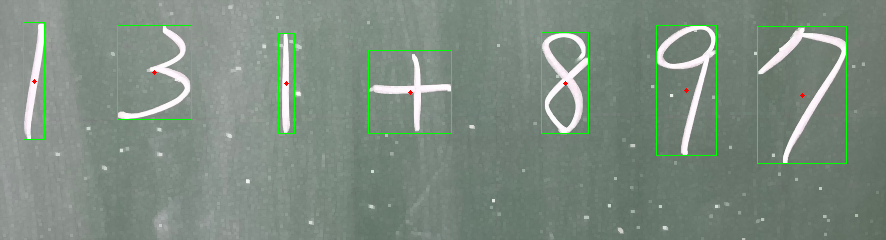

[1, 3, 1, 10, 8, 9, 7]
The equation is: 1 3 1 + 8 9 7 
The result is:  1028


In [83]:

def main():
    loss_train = []
    loss_valid = []
    epoch = 30
    lr = 10e-3
    momentum = 0.9
    fit(epoch, loss_train, loss_valid, lr, momentum)
    x = []
    for i in range(epoch):
        x.append(i)

    plt.plot(x, loss_train, label='train')
    plt.plot(x, loss_valid, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


if __name__ == '__main__':

  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  print('GPU State:', device)

  """ Training Model Uncomment This Part """
  # train = MnistDataset(dataset_path, transform=transform)
  # trainloader = DataLoader(
  #     dataset=train, batch_size=128, shuffle=True, num_workers=2)
  # # Test_Pic_to_CSV('C:/Users/user/Desktop/NN/Aug_Eval')
  # valid = MnistDataset(eval_path, transform=transform)
  # validloader = DataLoader(
  #     dataset=valid, batch_size=128 * 2, shuffle=True, num_workers=2)

  # main()
  """ End of training """

  """ Testing Uncomment This Part """
  Digit_Detector()
  Test_Pic_to_CSV(rLocate + Test_img)

  test = TestData(test_path, transform=transform)
  model = torch.load(model_path)
  model.eval()
  #
  Ans = []
  operator = ['0', '1', '2', '3', '4', '5',
              '6', '7', '8', '9', '+', '-', '*', '/']
  for i in range(len(test)):
      x = test[i, 1:]
      inputs = x[0].float()
      inputs = inputs.view(-1, 28*28).to(device)
      predict = model(inputs).cpu().detach().numpy()
      predict = softmax(predict)
      Ans.append(np.argmax(predict))

  equation = str()
  print(Ans)

  print('The equation is: ', end='')
  for i in Ans:
      equation += operator[i]
      print(operator[i], end=' ')
  # print(f'the equation is: {equation}')


  with open('Answer.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      Ans = eval(equation)
      writer.writerow(["Math equation", "Ans"])
      writer.writerow([equation, Ans])


  print(f'\nThe result is: ', Ans)
  """ End of testing """
